In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Source for SOFR rate: https://www.newyorkfed.org/markets/reference-rates/sofr

In [27]:
sofr_i=0.0533 ## SOFR Rate as on 09/12/2024
b_mat=30 ## Bond Maturity in years
bcr=0.055 ## Current Annualized Coupon Rate
cpy=4 ## Number of Coupons per year. For example, for a quarterly coupon this value will be 4.
bp=100 ## Face value of Bond

In [28]:
def DV01(maturity,face_value,coupon_rate,yield_rate,compounding):
    """
    This function requires the following variables:
        maturity: Maturity of the bond in years
        face_value: face value of the bond
        coupon_rate: annualized coupon rate of the bond
        yield_rate: yield rate of the bond 
        compounding: numerical value of the number of coupons in a year. Must be an integer.
        
    The functon returns the following data:
        B - Bond Price: Present value of the bond at a given yield rate
        D1 - Duration
        D2 - Modified Duration
        D3 - DV01
        bond_cf: List of cashflows from the bond given the compounding scheme
    """
    t=list(range(1,(maturity*compounding)+1))
    yld=yield_rate/compounding
    cpnr=coupon_rate/compounding
    cpnr_payment=face_value*cpnr
    bond_cf=[cpnr_payment]*len(t)
    bond_cf[len(t)-1]=bond_cf[len(t)-1]+face_value
    B=0
    D=0
    for i in range(1,len(t)+1):
        B+=bond_cf[i-1]/(1+yld)**i
    for j in range(1,len(t)+1):    
        D+=(j*bond_cf[j-1])/(((1+yld)**(j))*compounding)
    D1=D/B
    D2=D1/(1+yld)
    D3=D2*0.0001*B
    return B,D1,D2,D3,bond_cf

In [29]:
#DV01(30,100,0.055,0.0533,1) ## Test for DV01 function

A standard yield curve based on the SOFR has been simulated:
1. The "step" variable is assumed to be equal to 1 basis point
2. The "typ" variable takes in +/-1 depending on a normal or an inverted yield curve.
3. The generator attribute takes in the following inputs:
3.1. 0 for generating a flat yield curve
3.2. 1 for generating a linearly increasing yield curve
3.3. 2 for generating a quadratic spline with decreasing slope
3.4. 3 for generating a cubic spline with decreasing slope

Text(0, 0.5, 'Interest Rate')

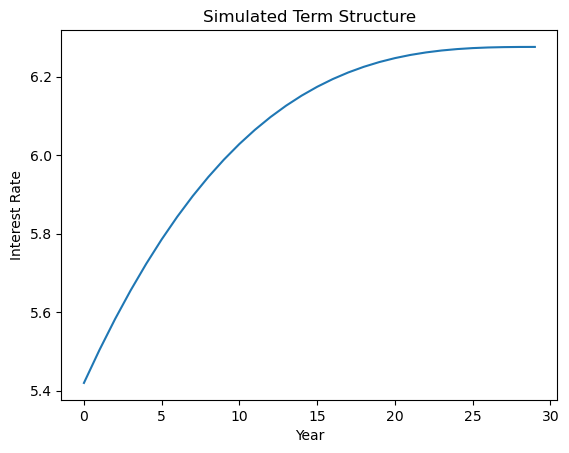

In [30]:
step=0.0001
def int_rate(ir,maturity,step,generator,typ=1):
    li=[]
    lit=ir
    p=0
    if generator==0:
        h=[0 for j in range(b_mat)]
        step_c=0
    elif generator==1:
        h=[1 for j in range(b_mat)]
        step_c=step
    elif generator==2:
        h=[b_mat-j for j in range(b_mat)]
        p=2
        step_c=step
    elif generator==3:
        h=[b_mat-j for j in range(b_mat)]
        p=3
        step_c=step
    for i in range(b_mat):
        lit=lit+typ*h[i]**p*step_c/(10**p)
        li.append(lit)
    return li

li=int_rate(sofr_i,b_mat,0.0001,2,1)
l=len(li)
li
g=[r*100 for r in li]    
plt.plot(g)
plt.title("Simulated Term Structure")
plt.xlabel("Year")
plt.ylabel("Interest Rate")

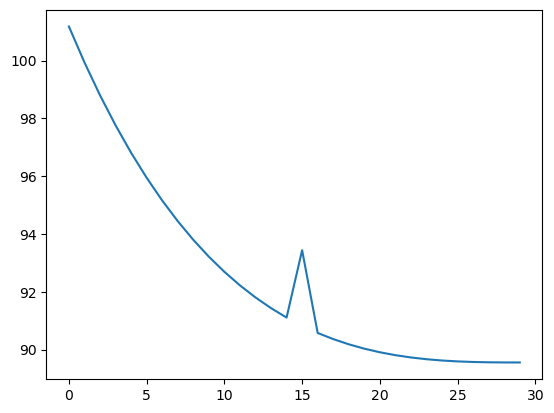

In [31]:
b=[]
dl1=[]
dl2=[]
dl3=[]
for k in range(l):
    b1,d1,d2,d3,cf1=DV01(b_mat,bp,bcr,li[k],cpy)
    if k==15: ## incoropating the put condition
        cf2=cf1[:k*cpy]
        cf2[len(cf2)-1]=cf2[len(cf2)-1]+bp
        e=len(cf2)
        B1=0
        D1=0
        yd=li[k]/cpy
        for i1 in range(1,e+1):
            B1+=cf2[i1-1]/(1+yd)**i1 ## generating current value of the bond with the put condition
        for j1 in range(1,e+1):    
            D1+=(j1*cf2[j1-1])/(((1+yd)**(j1))*cpy) ## generating numerator of duration of the bond with the put condition
        b.append(B1)
        dl1.append(d1*b1/B1) ## calculating duration of bond at option excercise
        dl2.append((d1*b1/B1)/(1+yd)) ## calculating modified duration of bond at option excercise
        dl3.append(((d1*b1/B1)/(1+yd))*0.0001*b1) ## calculating DV01 of bond at option excercise
    else:
        b.append(b1)
        dl1.append(d1)
        dl2.append(d2)
        dl3.append(d3)
plt.plot(b)

Since the present value of the bond, with the put option excercised is greater than what the value of the bond is without the put condition, it is logical to exercise the put option and reinvest the proceeds in more profitable ventures. The value of the bond will thus be more than that of a vanilla bond with the same maturity.

Text(15, 0.1229171581255473, 'x=15.000, y=0.123')

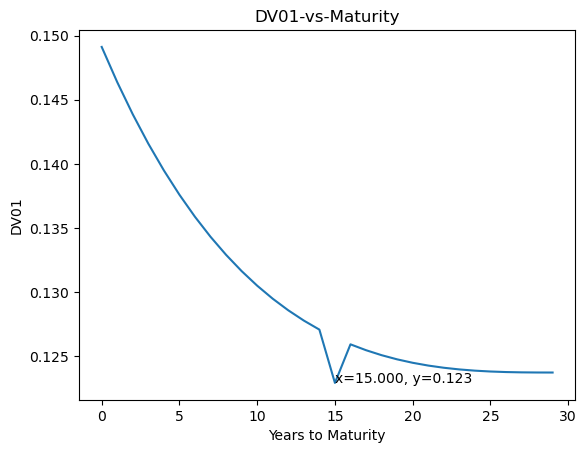

In [32]:
plt.plot(dl3)
plt.title("DV01-vs-Maturity")
plt.xlabel("Years to Maturity")
plt.ylabel("DV01")
ymax = min(dl3)
xmax = dl3.index(ymax)
text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
plt.annotate(text, xy=(xmax, ymax))

The maximum exposure will be just before the maturity of the put option at 15 years, since depending on the prevailing interest rates at the time the put option will either be excercised on the bond or it will be held till maturity.